In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
def conv_forward(A_prev, W, b, activation, padding="same", stride=(1, 1)):
    """
    Perform Froward propagation over a convolution layer.

    A_prev is a numpy.ndarray of shape (m, h_prev, w_prev, c_prev)
        containing the output of the previous layer
        m is the number of examples
        h_prev is the height of the previous layer
        w_prev is the width of the previous layer
        c_prev is the number of channels in the previous layer

    W is a numpy.ndarray of shape (kh, kw, c_prev, c_new)
    containing the kernels for the convolution
        kh is the filter height
        kw is the filter width
        c_prev is the number of channels in the previous layer
        c_new is the number of channels in the output

    b is a numpy.ndarray of shape (1, 1, 1, c_new) containing
    the biases applied to the convolution

    activation is an activation function applied to the convolution

    padding is a string that is either same or valid,
    indicating the type of padding used

    stride is a tuple of (sh, sw) containing the strides for the convolution
        sh is the stride for the height
        sw is the stride for the width
    """
    m, h, w, _ = A_prev.shape
    kh, kw, _, nc = W.shape
    sh, sw = stride
    if padding == 'valid':
        ph, pw = 0, 0
    else:
        ph = int(np.ceil((sh*(h-1)-h+kh)/2))
        pw = int(np.ceil((sw*(w-1)-w+kw)/2))
    oh = int((h+2*pw-kh)/sh+1)
    ow = int((w+2*pw-kw)/sw+1)
    npad = ((0, 0), (ph, ph), (pw, pw), (0, 0))
    A_pad = np.pad(A_prev, pad_width=npad, mode='constant')
    output = np.zeros((m, oh, ow, nc))
    for k in range(nc):
        filterk = W[:, :, :, k]
        for i in range(oh):
            for j in range(ow):
                x = i * sh
                y = j * sw
                to_conv = A_pad[:, x:x+kh, y:y+kw, :]
                output[:, i, j, k] = np.tensordot(to_conv, filterk, axes=3)

    output = activation(output + b)
    return output




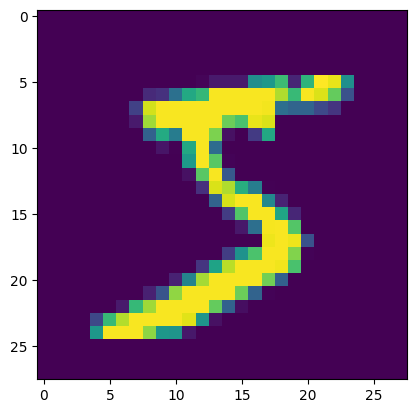

(50000, 26, 26, 2)


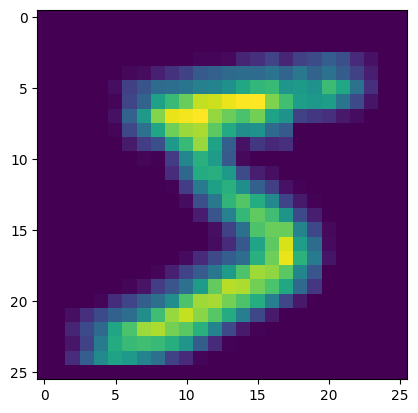

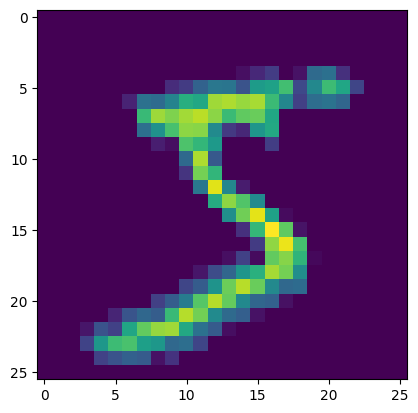

In [16]:

np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
m, h, w = X_train.shape
X_train_c = X_train.reshape((-1, h, w, 1))

W = np.random.randn(3, 3, 1, 2)
b = np.random.randn(1, 1, 1, 2)

def relu(Z):
    return np.maximum(Z, 0)

plt.imshow(X_train[0])
plt.show()
A = conv_forward(X_train_c, W, b, relu, padding='valid')
print(A.shape)
plt.imshow(A[0, :, :, 0])
plt.show()
plt.imshow(A[0, :, :, 1])
plt.show()